# IntroMLDA 2024 Spring. Unsupervised

**Борисочкин Михаил ML-12**

## Условие задачи

Вам предоставлен набор данных — некоторых вещественно значных признаков. Вам нужно проставить метки классов, другими словами кластеризовать данные. Данные представлены в виде sparse матрицы размера (14590, 77888).

Метрика оценки качества — Adjusted Rand Score.

In [137]:
from scipy import sparse
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, AgglomerativeClustering, SpectralClustering
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram

import numpy as np
import pandas as pd
import umap
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("whitegrid")

## Загрузка набора данных

In [2]:
train = sparse.load_npz("data/train.npz")

In [3]:
train_df = pd.DataFrame.sparse.from_spmatrix(train)

In [4]:
# Информация по датасету
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14590 entries, 0 to 14589
Columns: 77888 entries, 0 to 77887
dtypes: Sparse[float64, 0](77888)
memory usage: 23.2 MB


In [5]:
# train_df_dense = train_df.sparse.to_dense() # Занимает 8.5G памяти!

In [6]:
# Минимальные значения в 10 колонках датасета
train_df.min().sample(10, random_state=1)

1463     0
69250    0
63981    0
48431    0
12590    0
23573    0
66528    0
40071    0
72842    0
46814    0
dtype: Sparse[float64, 0]

In [7]:
# Количество уникальных значений в первой колонке
train_df[0].value_counts()

0
0.000000    14581
0.095032        1
0.036683        1
0.070927        1
0.142074        1
0.091247        1
0.276944        1
0.192160        1
0.157145        1
0.185288        1
Name: count, dtype: int64

In [8]:
# Количество уникальных значений во второй колонке
train_df[1].value_counts()

1
0.000000    14556
0.128201        1
0.056125        1
0.133719        1
0.128644        1
0.098548        1
0.048713        1
0.033855        1
0.193226        1
0.082070        1
0.126492        1
0.097075        1
0.041982        1
0.075676        1
0.052761        1
0.099496        1
0.195939        1
0.113747        1
0.073130        1
0.105067        1
0.135255        1
0.126696        1
0.067046        1
0.199006        1
0.043234        1
0.226162        1
0.093199        1
0.033905        1
0.134506        1
0.159981        1
0.109263        1
0.051805        1
0.081528        1
0.093078        1
0.118208        1
Name: count, dtype: int64

In [9]:
# Количество уникальных значений в третьей колонке
train_df[2].value_counts()

2
0.000000    14572
0.050582        1
0.052753        1
0.068740        1
0.105006        1
0.069669        1
0.069910        1
0.072668        1
0.106480        1
0.044305        1
0.039741        1
0.059377        1
0.086939        1
0.073095        1
0.057097        1
0.122904        1
0.036435        1
0.073502        1
0.041125        1
Name: count, dtype: int64

In [10]:
# Максимальные значения в 10 колонках датасета
train_df.max().sample(10, random_state=1)

1463     0.228049
69250    0.137103
63981    0.229385
48431    0.110389
12590    0.161607
23573    0.080603
66528     0.18121
40071    0.138316
72842    0.169644
46814    0.203041
dtype: Sparse[float64, 0]

In [11]:
# Самое большое значение во всём датасете
np.max(train_df.max())

0.7475549463482876

Все данные в исходном наборе данных находятся в диапазоне от 0 до 0,75. Масштабирование, в целом не требуется, но ради эксперимента попробуем отмасштабировать данные MaxAbsScaler-ом, так как он специально предназначен для разреженных данных.

In [12]:
train_scaled = MaxAbsScaler().fit_transform(train)
train_df_scaled = pd.DataFrame.sparse.from_spmatrix(train_scaled)
train_df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14590 entries, 0 to 14589
Columns: 77888 entries, 0 to 77887
dtypes: Sparse[float64, 0](77888)
memory usage: 23.2 MB


In [13]:
# Минимальные значения в 10 колонках датасета
train_df_scaled.min().sample(10, random_state=1)

1463     0
69250    0
63981    0
48431    0
12590    0
23573    0
66528    0
40071    0
72842    0
46814    0
dtype: Sparse[float64, 0]

In [14]:
train_df_scaled[0].value_counts()

0
0.000000    14581
0.343144        1
0.132455        1
0.256106        1
0.513007        1
0.329478        1
1.000000        1
0.693858        1
0.567424        1
0.669045        1
Name: count, dtype: int64

In [15]:
# Максимальные значения в 10 колонках датасета
train_df_scaled.max().sample(10, random_state=1)

1463     1.0
69250    1.0
63981    1.0
48431    1.0
12590    1.0
23573    1.0
66528    1.0
40071    1.0
72842    1.0
46814    1.0
dtype: Sparse[float64, 0]

In [16]:
# Самое большое значение во всём датасете
np.max(train_df_scaled.max())

1.0

В отмасштабированном наборе данных значения во всех колонках лежат на отрезке [0;1].

## Понижение размерности

Рассмотрим четыре метода понижения размерности: PCA, TruncatedSVD, t-SNE и UMAP. Каждый из них будем применять как к исходному, так и отмасштабированному набору данных. Понижать будем до двух компонентов.

In [17]:
def plot_and_get_dim_red_results(dim_red_method, dataset, scaled_dataset):
    """Функция для отображения результатов понижения размерности
    Parameters
    ----------
    dim_red_method
        Метод понижения размерности
    dataset
        Исходный набор данных
    scaled_dataset
        Отмасштабированный набор данных

    Returns
    -------
    df, df_scaled
        Исходный и отмасштабированный датасеты с пониженной размерностью
    """
    df = pd.DataFrame(dim_red_method.fit_transform(dataset), columns=["C1", "C2"])
    df_scaled = pd.DataFrame(
        dim_red_method.fit_transform(scaled_dataset), columns=["C1", "C2"]
    )

    _, ax = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))
    sns.scatterplot(df, x="C1", y="C2", ax=ax[0])
    sns.scatterplot(df_scaled, x="C1", y="C2", ax=ax[1])

    ax[0].set_title("Исходные данные")
    ax[1].set_title("Отмасштабированные данные")
    plt.show()

    return df, df_scaled

### PCA

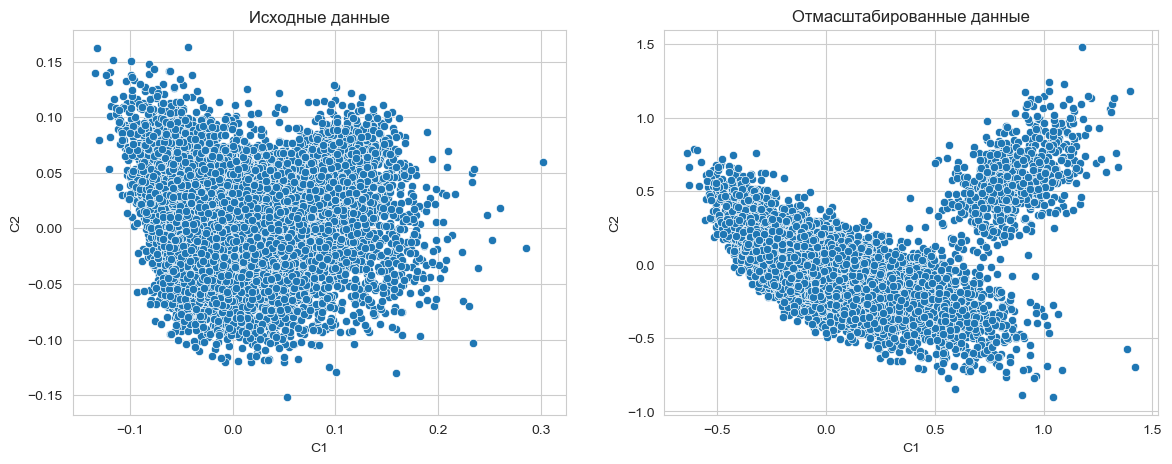

In [18]:
pca = PCA(n_components=2, random_state=42, svd_solver="arpack")

df_pca, df_pca_scaled = plot_and_get_dim_red_results(pca, train_df, train_df_scaled)

In [19]:
# Значение объяснённой дисперсии
pca.explained_variance_ratio_.sum()

0.004538230515873115

На отмасштабированных данных видно два чётких кластера, но значение объяснённой дисперсии слишком мало, что бы использовать результат PCA для дальнейшей кластеризации.

### Truncated SVD

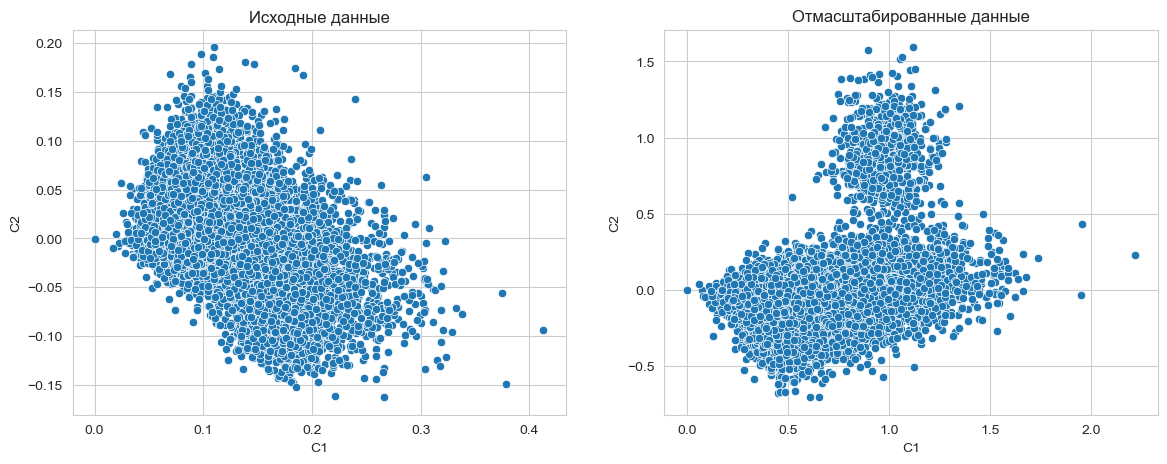

In [20]:
tsvd = TruncatedSVD(n_components=2, random_state=42)
df_tsvd, df_tsvd_scaled = plot_and_get_dim_red_results(tsvd, train_df, train_df_scaled)

In [21]:
# Доля объяснённой дисперсии
tsvd.explained_variance_ratio_.sum()

0.003937443750784794

Truncated SVD также лучше показал себя на отмасштабироанных данный, хотя и не так хорошо, как PCA. Его мы тоже не будем использовать из-за низкого значения доли объяснённой дисперсии.

### t-SNE

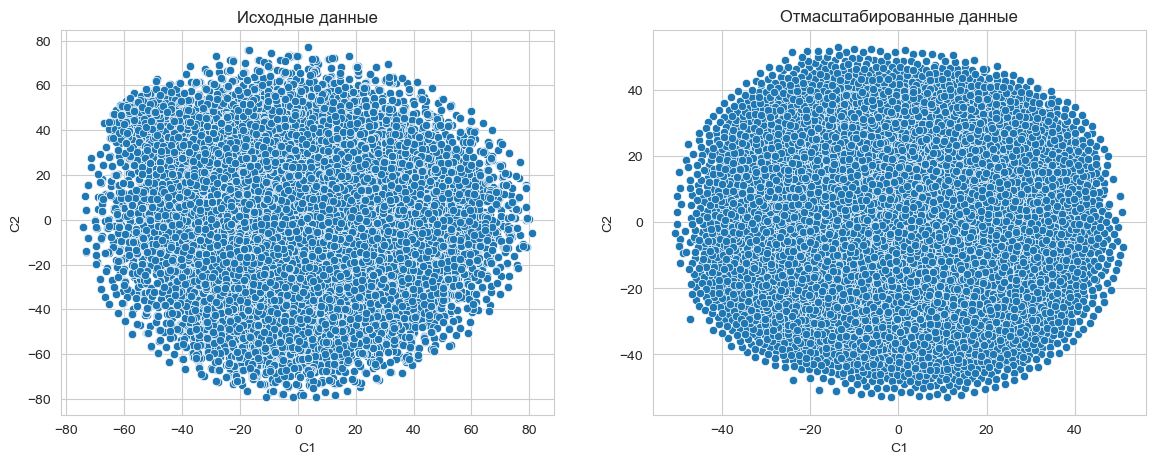

In [22]:
tsne = TSNE(
    n_components=2, learning_rate="auto", init="random", random_state=42, n_jobs=-1
)

df_tsne, df_tsne_scaled = plot_and_get_dim_red_results(tsne, train_df, train_df_scaled)

На результатах t-SNE видно только один большой кластер, да и считал он долго.

### UMAP

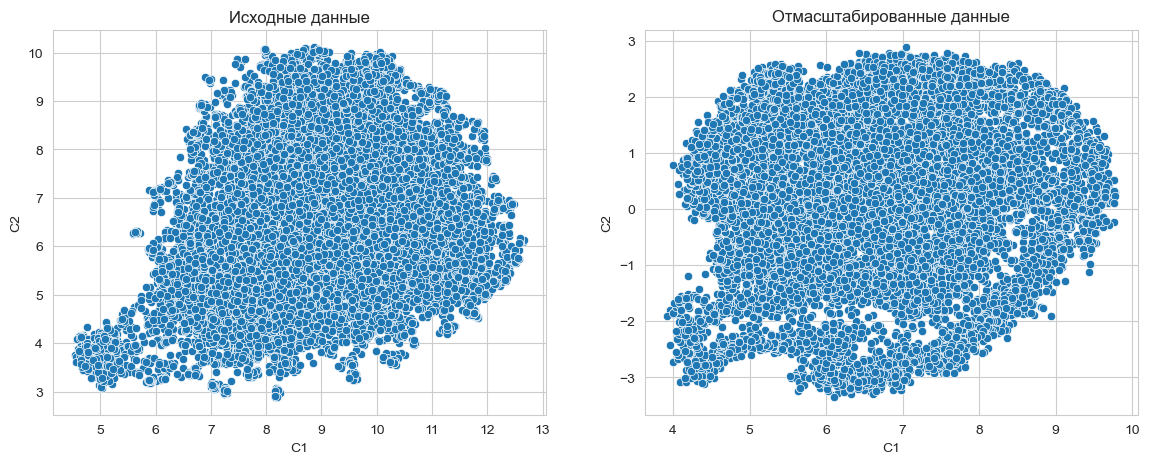

In [23]:
reducer = umap.UMAP(n_components=2)

df_umap, df_umap_scaled = plot_and_get_dim_red_results(
    reducer, train_df, train_df_scaled
)

UMAP сработал лучше и быстрее t-SNE. Будем использовать его (за неимением лучшего).

### Итоговый метод понижения размерности

In [62]:
reducer_3d = umap.UMAP(n_components=3)
reducer_4d = umap.UMAP(n_components=4)

df_umap_3d, df_umap_4d = (
    reducer_3d.fit_transform(train_df),
    reducer_4d.fit_transform(train_df),
)

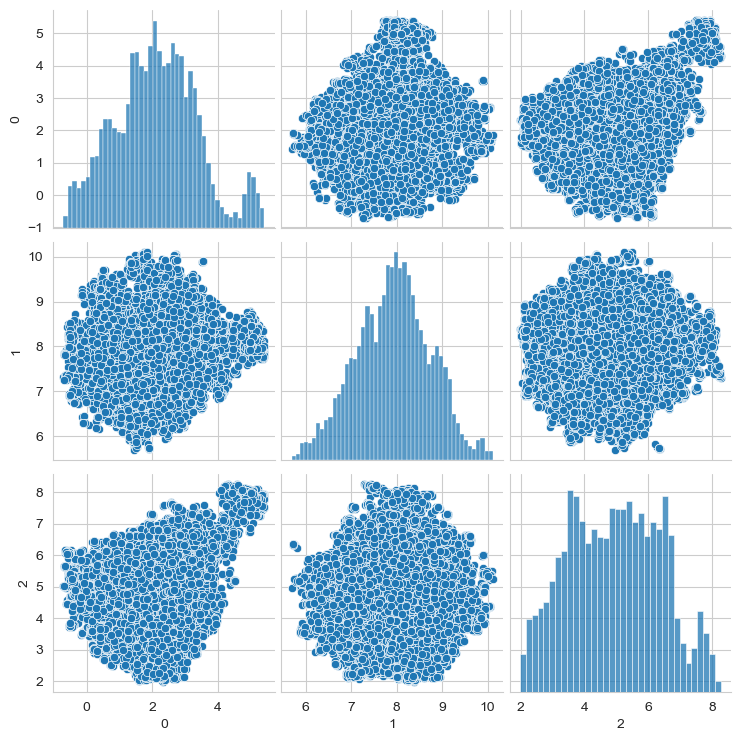

In [63]:
sns.pairplot(pd.DataFrame(df_umap_3d))
plt.show()

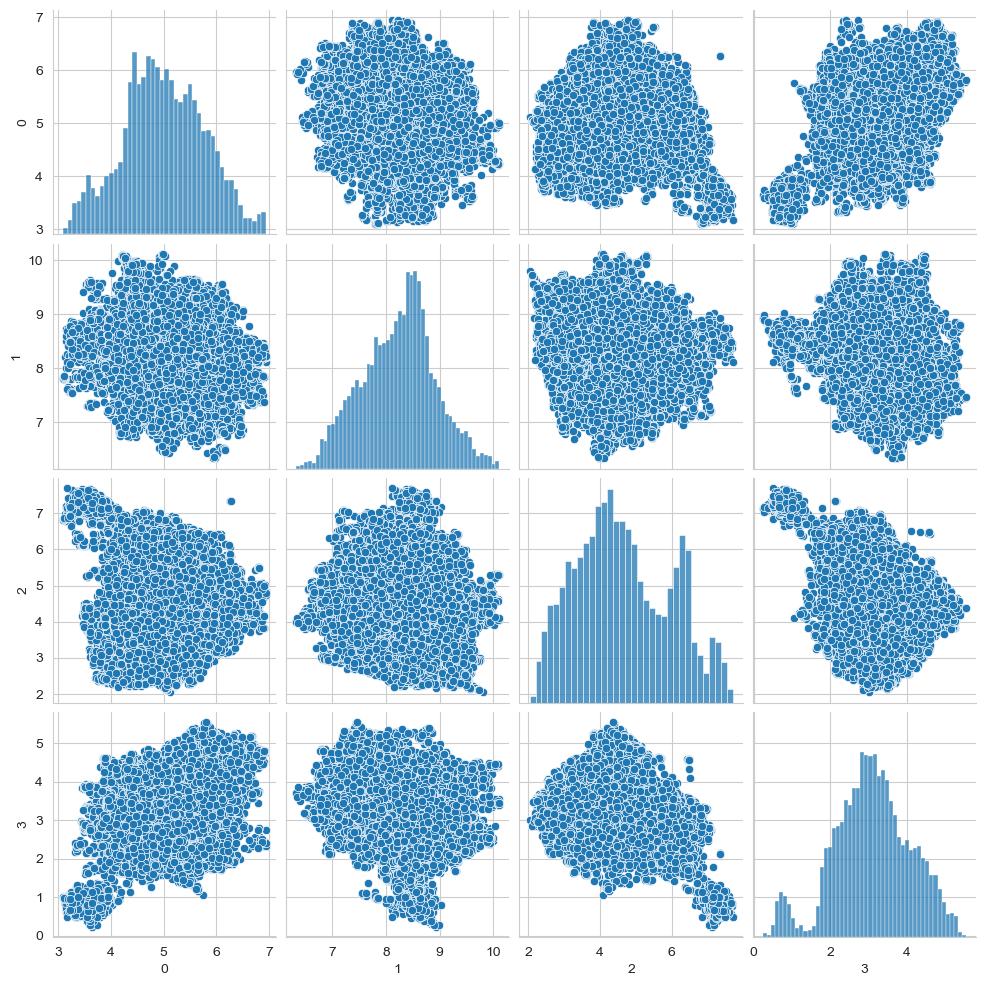

In [65]:
sns.pairplot(pd.DataFrame(df_umap_4d))
plt.show()

## Кластеризация

Для кластеризации будем использовать следующие методы: метод k-средних, аггломеративную кластеризацию, спектральную кластеризацию и гауссовы смеси.

Ввиду отсутствия истинных меток кластеров для будем использовать меру силуэта.

In [208]:
# Списки для формирования графика сравнения моделей
model_names = [
    "KMeans",
    "AgglomerativeClustering",
    "SpectralClustering",
    "GaussianMixture",
]
silhouette_scores = []

### KMeans

Первым делом проверим количество кластеров с помощью метода локтя.

In [176]:
def plot_inertia(dataset, method):
    """Функция для визуализации инерции
    Parameters
    ----------
    dataset
        Набор данных для обучения
    method
        Метод кластеризации

    Returns
    -------
        None
    """
    _, a = plt.subplots(figsize=(10, 5))
    inertia = []
    temp_x = dataset
    for k in range(1, 21):
        kmeans = method(n_clusters=k).fit(temp_x)
        inertia.append(kmeans.inertia_)
    sns.pointplot(x=np.arange(1, 21), y=inertia, ax=a)
    plt.xlabel("K")
    plt.ylabel("Инерция")
    plt.show()

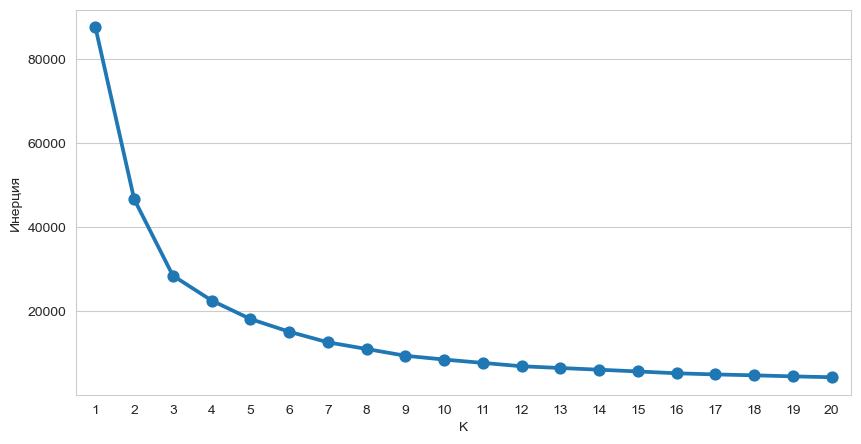

In [177]:
# Метод локтя для 2d
plot_inertia(df_umap, KMeans)

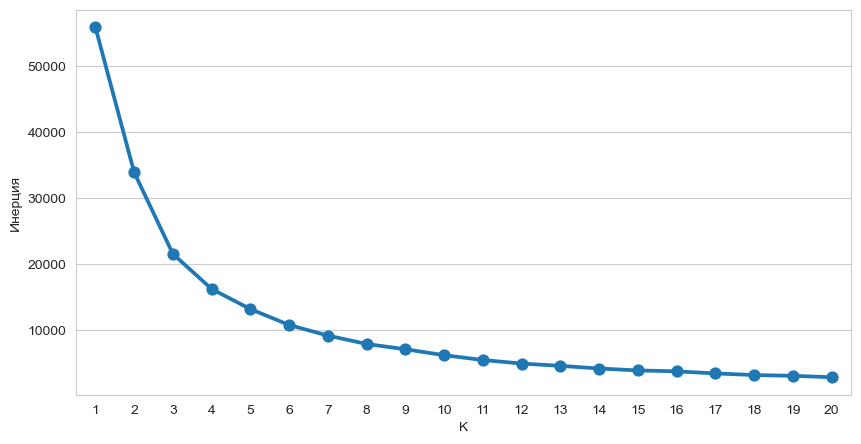

In [178]:
# Метод локтя для 2d от масштабированных данных
plot_inertia(df_umap_scaled, KMeans)

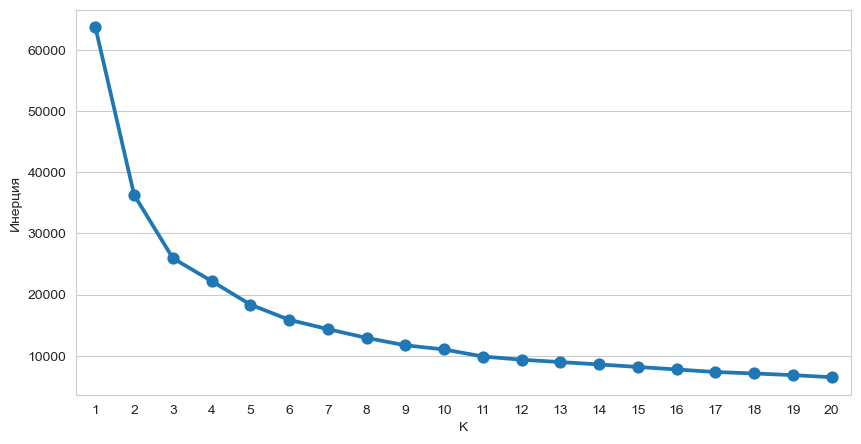

In [179]:
# Метод локтя для 3d
plot_inertia(df_umap_3d, KMeans)

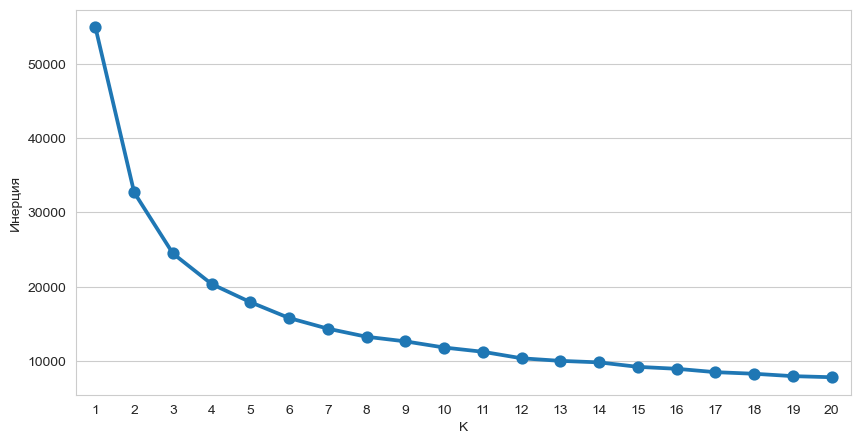

In [180]:
# Метод локтя для 4d
plot_inertia(df_umap_4d, KMeans)

Для всех размерностей "локтём" является тройка. Возьмём её для всех используемых в данной работе методов. Кластеровать будем на наборе данных из четырёх измерений, так как там наиболее выражены кластеры.

In [209]:
kmeans = KMeans(n_clusters=3, random_state=42)

In [210]:
y_pred = kmeans.fit_predict(df_umap_4d)

In [211]:
silhouette_scores.append(silhouette_score(df_umap_4d, y_pred))
silhouette_scores[-1]

0.32475886

### Аггломеративная кластеризация

In [212]:
agglo_clust = AgglomerativeClustering(n_clusters=3, compute_distances=True)

In [213]:
y_pred = agglo_clust.fit_predict(df_umap_4d)

In [214]:
silhouette_scores.append(silhouette_score(df_umap_4d, y_pred))
silhouette_scores[-1]

0.27721035

In [159]:
# Функция для построения дендрограммы (взята с sklrean)
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

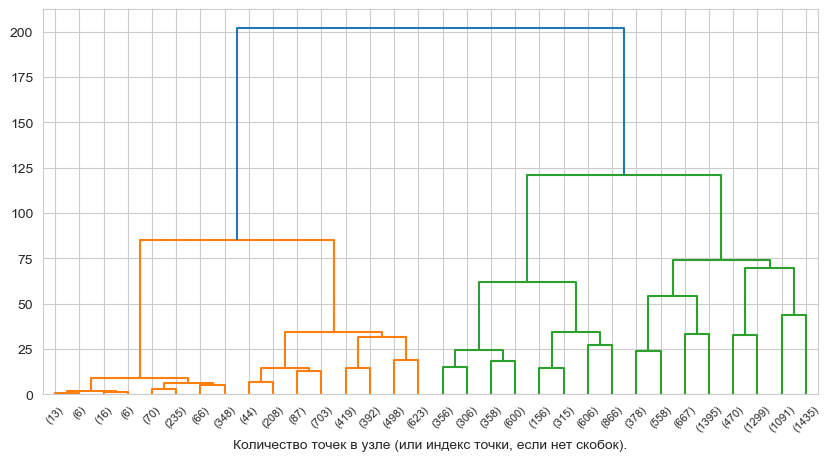

In [160]:
_, ax = plt.subplots(figsize=(10, 5))

plot_dendrogram(agglo_clust, truncate_mode="level", p=4, ax=ax)
plt.xlabel("Количество точек в узле (или индекс точки, если нет скобок).")
plt.show()

### Спектральная кластеризация

In [215]:
spectral_clust = SpectralClustering(n_clusters=3)

In [216]:
y_pred = spectral_clust.fit_predict(df_umap_4d)

In [217]:
silhouette_scores.append(silhouette_score(df_umap_4d, y_pred))
silhouette_scores[-1]

0.32527125

### Гауссовы смеси

Для гауссовых смесей проверим разные значения типа ковариации.

In [171]:
covariance_types = ["full", "diag", "tied", "spherical"]

for covariance_type in covariance_types:
    gaussian_clust = GaussianMixture(
        n_components=3, covariance_type=covariance_type, random_state=42
    )
    y_pred = gaussian_clust.fit_predict(df_umap_4d)
    print(f"{covariance_type}: {silhouette_score(df_umap_4d, y_pred)}")

full: 0.29573267698287964
diag: 0.32036492228507996
tied: 0.31829115748405457
spherical: 0.3245103657245636


Лучшим вариантом оказался сферический тип ковариации.

In [218]:
gaussian_clust = GaussianMixture(
    n_components=3, covariance_type="spherical", random_state=42
)

In [219]:
y_pred = gaussian_clust.fit_predict(df_umap_4d)

In [220]:
silhouette_scores.append(silhouette_score(df_umap_4d, y_pred))
silhouette_scores[-1]

0.32451037

### Сравнение моделей

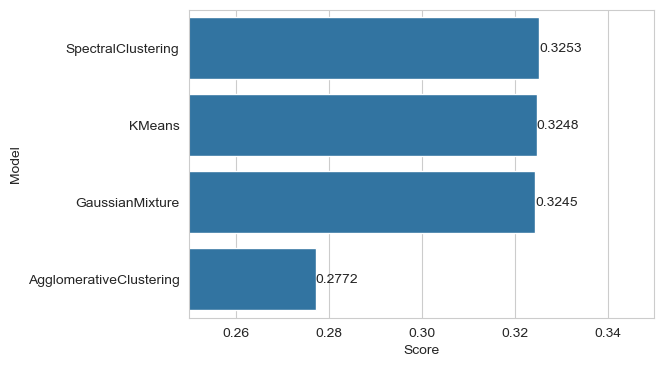

In [226]:
barplot_df = pd.DataFrame({"Model": model_names, "Score": silhouette_scores})
barplot_df["Score"] = barplot_df["Score"].apply(lambda x: round(x, 4))
_, ax = plt.subplots(figsize=(6, 4))
sns.barplot(
    barplot_df,
    y="Model",
    x="Score",
    order=barplot_df.sort_values("Score", ascending=False).Model,
    ax=ax,
)
ax.set_xlim(0.25, 0.35)
ax.bar_label(ax.containers[0])
plt.show()

Исходя из графика, лучше всего себя показывает спектральная кластеризация, на втором месте — метод k-средних, на третьем — смеси Гаусса. Хуже всего себя показала аггломеративная кластеризация.

## Submission

In [123]:
submission = pd.DataFrame({"ID": np.arange(train.shape[0]), "TARGET": y_pred})

submission.to_csv("submission.csv", index=False)

### Результаты submission

По результатам submission модели расположились в следующем порядке:

1. Смеси Гаусса: 0,139
2. Метод k-средних: 0,136
3. Аггломеративная кластеризация: 0,130
4. Спектральная кластеризация: *-0,027*

## Итоги

В процессе работы были рассмотрены четыре метода понижения размерности и четыре метода кластеризации и получены следующие выводы:

- Для методов понижения размерности PCA и SVD лучше отмасштабировать исходные данные. Для t-SNE и UMAP делать это не обязательно, но желательно.
- Мера силуэта не сильно отражает ARI, что прекрасно видно на примере спектральной кластеризации. Оценивать качество кластеризации проще, имея истинные метки.
- Формат хранения CSR для разреженных данных очень крутой: занимает гораздо меньше места, чем "плотный" аналог. Однако не все методы понижения размерности умеют работать с такими данными (например, MDS).